## Module imports

In [1]:
from os import chdir
from pathlib import Path
import warnings

# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
if "notebooks" in str(Path.cwd()):
    chdir("..")

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib

import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    get_workingdays,
)

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Notebook Constants

In [2]:
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
HISTORICAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region, historical"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "num_appointments"
USED_APPOINTMENT_COLUMNS = ["SUB_ICB_LOCATION_CODE","APPOINTMENT_MONTH","HCP_TYPE","COUNT_OF_APPOINTMENTS"]

# 1. Data loading

## 1.1. Load Catalog

In [3]:
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

## 1.2. Appointments SUB-ICB level

In [4]:
def load_all_areas_gp_appts(catalog_entry_name:str) ->pd.DataFrame:
    catalog_entry = catalog.get_catalog_entry_by_name(catalog_entry_name)
    _ = catalog_entry.load()

    dfs_ = []
    for ccg_name in catalog_entry.zip_file.namelist():
        catalog_entry.csv_file = ccg_name
        dfs_.append(catalog_entry.load())

    combined_df_ = pd.concat(dfs_, axis=0)

    combined_df_ = combined_df_.rename(columns={'CCG_CODE':'SUB_ICB_LOCATION_CODE',
                                                          'Appointment_Month':'APPOINTMENT_MONTH'})
    
    combined_df_ = combined_df_.loc[:,USED_APPOINTMENT_COLUMNS]
    try:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
    except:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'], format='%b-%y')
    
    return combined_df_

latest_gp_appts_df = load_all_areas_gp_appts(REGIONAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = load_all_areas_gp_appts(HISTORICAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = historical_gp_appts_df.loc[~historical_gp_appts_df['APPOINTMENT_MONTH'].isin(latest_gp_appts_df['APPOINTMENT_MONTH'].unique())]
all_area_appts_df = pd.concat([latest_gp_appts_df, historical_gp_appts_df], axis=0)

# 2. EDA

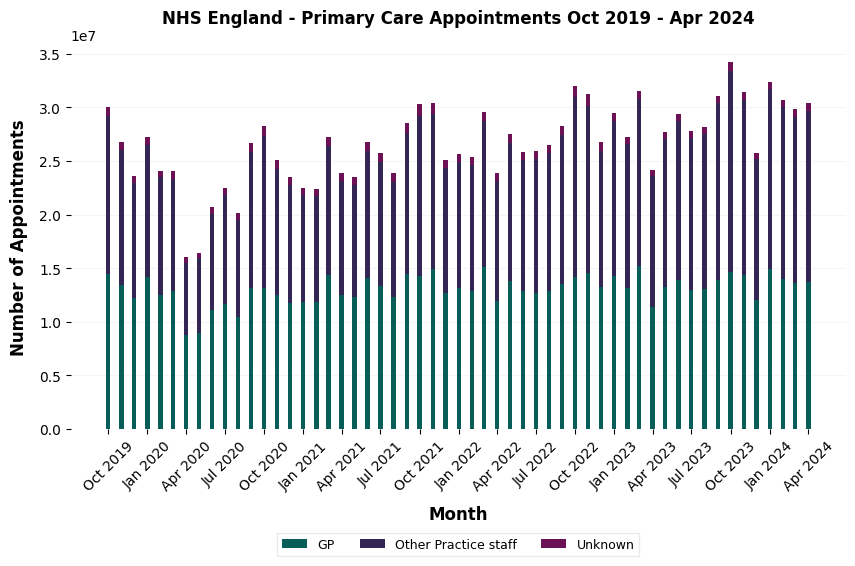

In [5]:
def stacked_bar_appointments(
    df: pd.DataFrame, title: str, ylabel: str, xlabel: str, figsize=(10, 5)
):
    fig, ax = plt.subplots(figsize=figsize)

    months = df["APPOINTMENT_MONTH"].unique()

    bottoms = np.zeros(len(months))
    for hcp_type in df["HCP_TYPE"].unique():
        hcp_type_slice = df[df["HCP_TYPE"] == hcp_type].copy()
        p = ax.bar(
            months,
            hcp_type_slice["COUNT_OF_APPOINTMENTS"].values,
            width=10,
            bottom=bottoms,
            label=hcp_type,
        )
        bottoms += hcp_type_slice["COUNT_OF_APPOINTMENTS"].values
    date_range = (
        str([f"{i.strftime('%b %Y')}" for i in [months.min(), months.max()]])[1:-1]
        .replace("'", "")
        .replace(",", " -")
    )
    ax.set_title(f"{title} {date_range}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)
    plt.savefig(f"{plot_counter.plot_name}.png")
    plt.show()


stacked_bar_appointments(
    all_area_appts_df.groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[
        ["COUNT_OF_APPOINTMENTS"]
    ]
    .sum()
    .reset_index(),
    "NHS England - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

- No obvious seasonality

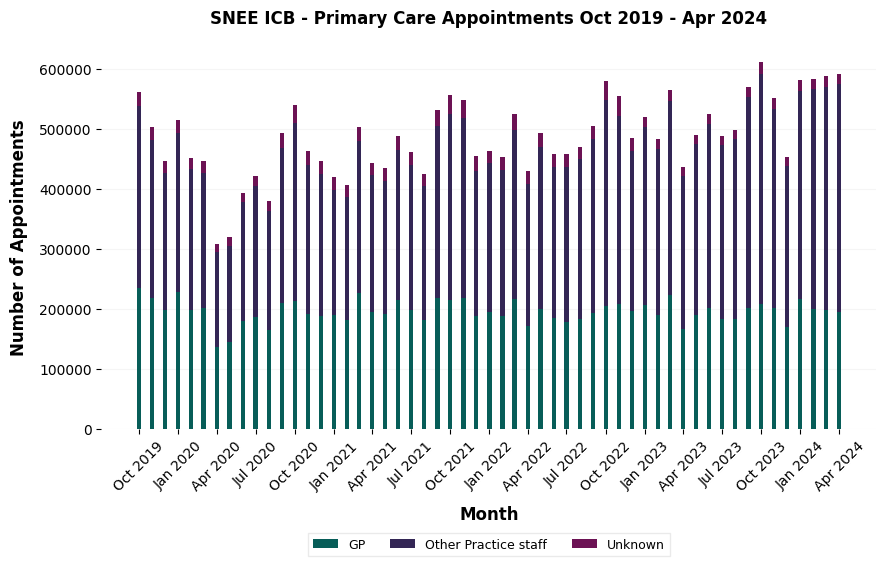

In [6]:
snee_appointments_df = (
    all_area_appts_df.loc[
        all_area_appts_df["SUB_ICB_LOCATION_CODE"].isin(
            list(const.SUB_ICB_CODES.keys())
        )
    ]
    .groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
stacked_bar_appointments(
    snee_appointments_df,
    "SNEE ICB - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

In [7]:
# divide by working days/month to get average appointments per day
monthly_appts_df = snee_appointments_df.groupby('APPOINTMENT_MONTH').sum(numeric_only=True)
monthly_appts_df = monthly_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_appts_df.index))
monthly_appts_df = monthly_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_appts_df['WORKING_DAYS'])
monthly_appts_df.index.freq = 'MS' # set frequency to month start

## 2.1. Check stationarity - overall


In [8]:
# Assume 'data' is your time series data in a pandas Series
result = statsmodels.tsa.stattools.adfuller(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value < 0.05, the data is stationary
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")

ADF Statistic: 0.05044540726141728
p-value: 0.9625103111565132
The data is not stationary.


## 2.2. For Sub-ICBs

In [9]:
sub_icb_demand_df = all_area_appts_df.groupby(['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH']).sum(numeric_only=True).reset_index().set_index('APPOINTMENT_MONTH')
sub_icb_demand_df = sub_icb_demand_df.assign(WORKING_DAYS=get_workingdays(sub_icb_demand_df.index))
sub_icb_demand_df = sub_icb_demand_df.assign(AVG_APPTS_PER_WORKING_DAY=sub_icb_demand_df['COUNT_OF_APPOINTMENTS'] / sub_icb_demand_df['WORKING_DAYS'])

for sub_icb in const.SUB_ICB_CODES.keys():
    # Assume 'data' is your time series data in a pandas Series
    print(f"SUB_ICB: {const.SUB_ICB_CODES[sub_icb]}")
    result =statsmodels.tsa.stattools.adfuller(sub_icb_demand_df.loc[sub_icb_demand_df['SUB_ICB_LOCATION_CODE']==sub_icb, 'AVG_APPTS_PER_WORKING_DAY'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # If p-value < 0.05, the data is stationary
    if result[1] < 0.05:
        print("The data is stationary.\n")
    else:
        print("The data is not stationary.\n")

SUB_ICB: Ipswich & East Suffolk
ADF Statistic: 0.4712611067351204
p-value: 0.9839729232982612
The data is not stationary.

SUB_ICB: West Suffolk
ADF Statistic: 0.6216640537701472
p-value: 0.9881376150462314
The data is not stationary.

SUB_ICB: North East Essex
ADF Statistic: -2.694164667802683
p-value: 0.07505349109951959
The data is not stationary.



## 2.3. Clear seasonality

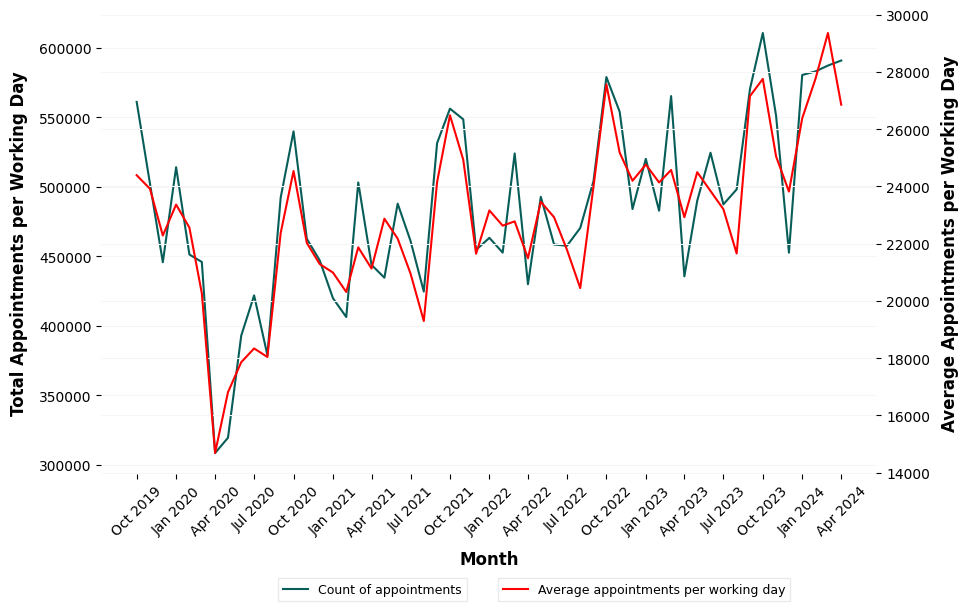

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(monthly_appts_df['COUNT_OF_APPOINTMENTS'], label='Count of appointments')
ax2.plot(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], color='r', label='Average appointments per working day')
ax2.set_ylabel('Average Appointments per Working Day')
ax.set_ylabel('Total Appointments per Working Day')
ax.set_xlabel('Month')
# change x axis format to month, year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='center', bbox_to_anchor=(0.35, -0.25), ncol=1)
ax2.legend(loc='center', bbox_to_anchor=(0.7, -0.25), ncol=1)
plt.show()

## 2.4. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


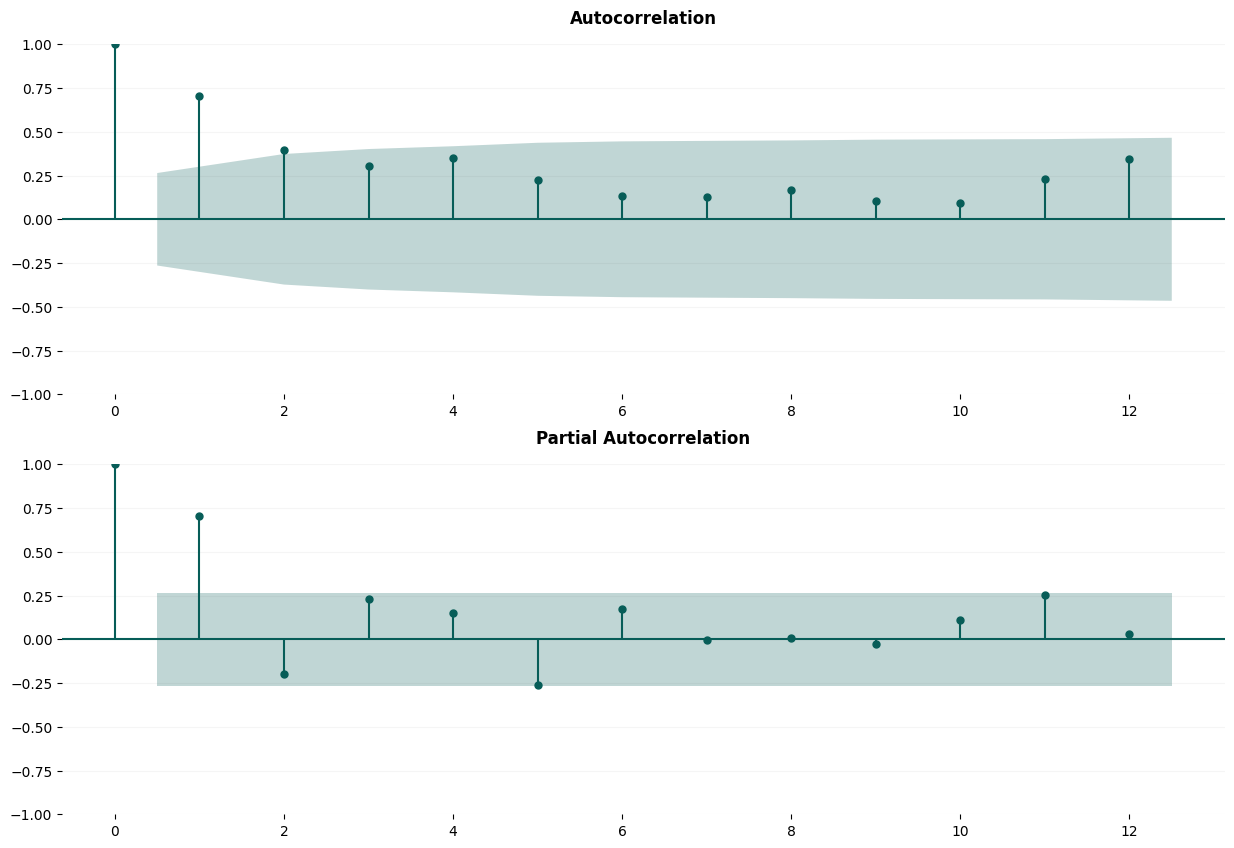

In [11]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[0])
plot_pacf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[1])
plt.show()

## 2.5. Decompostion

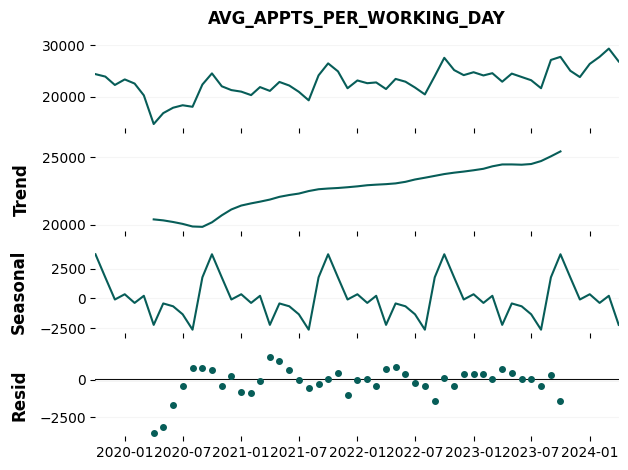

In [12]:
# Decompose the time series
result = seasonal_decompose(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], model='additive', period=12)

# Plot the decomposition
result.plot()
plt.show()

## 2.6. Multiply by population

In [13]:
## Multiply by population scenarios to get total appointments
pop_scenarios = {scenario.name: scenario.load() for scenario in catalog.scenario_data_sources[0].scenarios}

pop_scenarios['Principal projection'].loc[pop_scenarios['Principal projection']['AGE_GROUP'] == 'All ages'].head(5)

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
91,E38000004,NHS Barking and Dagenham CCG,Population,persons,All ages,211998.0,213423.294,214681.387,215836.155,216826.434,...,222626.633,223110.809,223618.121,224171.031,224774.823,225392.580,226012.162,226630.010,227249.839,227861.856
183,E38000005,NHS Barnet CCG,Population,persons,All ages,392140.0,395978.585,399641.401,403014.949,406061.106,...,428700.107,430291.496,431862.378,433455.467,435109.164,436755.036,438375.287,439977.126,441569.236,443146.254
275,E38000011,NHS Bexley CCG,Population,persons,All ages,247258.0,248428.446,249590.212,250759.372,251931.170,...,263924.110,264952.556,265991.059,267059.085,268179.631,269308.813,270445.395,271588.236,272739.193,273897.526
367,E38000020,NHS Brent CCG,Population,persons,All ages,330795.0,333311.812,335438.751,337289.458,338873.083,...,350379.684,351371.184,352343.136,353321.358,354293.294,355244.773,356152.099,357011.597,357831.971,358617.807
459,E38000023,NHS Bromley CCG,Population,persons,All ages,331096.0,332838.420,334612.410,336487.631,338249.835,...,353152.406,354187.087,355236.812,356347.166,357570.088,358814.014,360078.016,361367.877,362696.232,364053.536


# 3. Load GP lists data for all areas

In [14]:
gp_list_df = catalog.get_catalog_entry_by_name(
    "Patients Registered at a GP practice, October 2023"
).load()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


## 3.1. Feature Engineering

### 3.1.1. Convert population to proportions of population and add 5 year bin

In [15]:
# keep gendered data, and age groups
def convert_gp_list_to_five_year_bins(df: pd.DataFrame) -> pd.Series:
    """
    Converts the GP list dataframe to a new dataframe with age groups grouped into five-year bins.

    Args:
        gp_list_df (pd.DataFrame): The input GP list dataframe.

    Returns:
        pd.DataFrame: The converted dataframe with age groups grouped into five-year bins.
    """

    # Filter the GP list dataframe based on specific conditions
    gp_list_df_ = df.loc[
        (df["ORG_TYPE"] == "SUB_ICB_LOCATION")
        & (df["SEX"] != "ALL")
        & (df["AGE_GROUP_5"] != "ALL")
    ].copy()

    # Select specific columns from the filtered dataframe
    gp_list_df_ = gp_list_df_.loc[:, ["ORG_CODE", "SEX", "AGE_GROUP_5", "NUMBER_OF_PATIENTS"]]

    # Modify the age group values
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].replace(
        {"90_94": "90+", "95+": "90+"}
    )
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].str.replace("_", "-")

    # Pivot table to get age group as columns
    gp_list_df_ = gp_list_df_.pivot_table(
        index="ORG_CODE", columns="AGE_GROUP_5", values="NUMBER_OF_PATIENTS", aggfunc="sum"
    )
    return gp_list_df_


def convert_5_year_gp_list_to_proportional(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a DataFrame of 5-year GP appointment counts to proportional values.

    Args:
        df (pd.DataFrame): The input DataFrame containing 5-year GP appointment counts.

    Returns:
        pd.DataFrame: The DataFrame with the appointment counts converted to proportional values.
    """
    total_appointments = df.div(df.sum(axis=1), axis=0)
    return total_appointments


# Apply the functions
gp_list_proportional_areas_df = (gp_list_df
                                 .pipe(convert_gp_list_to_five_year_bins)
                                 .pipe(convert_5_year_gp_list_to_proportional))

gp_list_5yr_bins:pd.DataFrame = gp_list_df.pipe(convert_gp_list_to_five_year_bins)

gp_list_area_totals:pd.Series = gp_list_5yr_bins.sum(axis=1)
gp_list_area_totals.name = "NUMBER_OF_PATIENTS"

In [16]:
gp_list_proportional_areas_df.head(5)

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,0.055354,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00N,0.046318,0.056702,0.052957,0.048391,0.058945,0.071641,0.073194,0.066699,0.056026,0.054780,0.066198,0.072568,0.070651,0.060197,0.049951,0.042973,0.025699,0.017080,0.009032
00P,0.045493,0.056224,0.055058,0.054358,0.066509,0.074500,0.071698,0.064883,0.055768,0.052966,0.067178,0.069287,0.066296,0.058151,0.049276,0.042159,0.025396,0.016355,0.008447
00Q,0.056114,0.073327,0.069254,0.062584,0.067123,0.071613,0.073718,0.071445,0.061244,0.067286,0.065642,0.061721,0.053456,0.043510,0.036411,0.030505,0.018341,0.010841,0.005862
00R,0.046429,0.056044,0.054101,0.050338,0.059426,0.070912,0.069837,0.062282,0.055081,0.054717,0.069495,0.076881,0.070049,0.057242,0.047807,0.045427,0.028257,0.017382,0.008293


In [17]:
gp_list_5yr_bins.head(5)

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,13705,18127,17354,15141,16987,18960,19454,19388,18668,16411,23071,26075,26494,23742,21879,19933,11297,6917,3643
00N,7395,9053,8455,7726,9411,11438,11686,10649,8945,8746,10569,11586,11280,9611,7975,6861,4103,2727,1442
00P,13265,16394,16054,15850,19393,21723,20906,18919,16261,15444,19588,20203,19331,16956,14368,12293,7405,4769,2463
00Q,10347,13521,12770,11540,12377,13205,13593,13174,11293,12407,12104,11381,9857,8023,6714,5625,3382,1999,1081
00R,8291,10008,9661,8989,10612,12663,12471,11122,9836,9771,12410,13729,12509,10222,8537,8112,5046,3104,1481


In [18]:
gp_list_area_totals.head(5)

ORG_CODE
00L    337246
00N    159658
00P    291585
00Q    184393
00R    178574
Name: NUMBER_OF_PATIENTS, dtype: int64

### 3.1.2. Find total appointments per sub-icb per month with the list size

In [19]:
# total appointments per sub-icb per month with the list size
all_area_appts_df = (
    all_area_appts_df.loc[
        :, ["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH", "COUNT_OF_APPOINTMENTS"]
    ]
    .groupby(["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
all_area_appts_df = (
    all_area_appts_df.set_index("SUB_ICB_LOCATION_CODE")
    .join(gp_list_area_totals)
    .reset_index()
)

all_area_appts_df.head(5)

,index,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,NUMBER_OF_PATIENTS
0,00L,2019-10-01,203441,337246
1,00L,2019-11-01,177033,337246
2,00L,2019-12-01,156654,337246
3,00L,2020-01-01,181879,337246
4,00L,2020-02-01,157515,337246


#### Number of appointments per month per person

(considers the 2023 population only)

In [20]:
# calculate appointments per person per month
all_area_appts_df = all_area_appts_df.assign(
    gp_appts_per_person=lambda df: df["COUNT_OF_APPOINTMENTS"] / df["NUMBER_OF_PATIENTS"]
).drop(columns=["COUNT_OF_APPOINTMENTS", "NUMBER_OF_PATIENTS"])
all_area_appts_df

,index,APPOINTMENT_MONTH,gp_appts_per_person
0,00L,2019-10-01,0.603242
1,00L,2019-11-01,0.524937
2,00L,2019-12-01,0.464510
3,00L,2020-01-01,0.539307
4,00L,2020-02-01,0.467063
...,...,...,...
5825,X2C4Y,2023-12-01,0.521097
5826,X2C4Y,2024-01-01,0.644686
5827,X2C4Y,2024-02-01,0.590500
5828,X2C4Y,2024-03-01,0.573236


### 3.1.3. Add Working days/month
- Calculate appointments per working day
- drop unused columns

In [21]:
# get working days/month
all_area_appts_df["working_days"] = get_workingdays(
    all_area_appts_df["APPOINTMENT_MONTH"].dt
)
# calculate appointments per person per working day
all_area_appts_df["appts_per_person_per_workingday"] = (
    all_area_appts_df["gp_appts_per_person"] / all_area_appts_df["working_days"]
)
# get the month as a number
all_area_appts_df["month"] = all_area_appts_df["APPOINTMENT_MONTH"].dt.month
# drop columns
all_area_appts_df = all_area_appts_df.drop(
    columns=["working_days", "gp_appts_per_person", "APPOINTMENT_MONTH"]
)
all_area_appts_df

,index,appts_per_person_per_workingday,month
0,00L,0.026228,10
1,00L,0.024997,11
2,00L,0.023225,12
3,00L,0.024514,1
4,00L,0.023353,2
...,...,...,...
5825,X2C4Y,0.027426,12
5826,X2C4Y,0.029304,1
5827,X2C4Y,0.028119,2
5828,X2C4Y,0.028662,3


In [22]:
complete_dataset_df = all_area_appts_df.set_index("index").join(gp_list_proportional_areas_df)
complete_dataset_df

,appts_per_person_per_workingday,month,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
00L,0.026228,10,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024997,11,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023225,12,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024514,1,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023353,2,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2C4Y,0.027426,12,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.029304,1,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028119,2,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028662,3,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402


# 4. Modelling

## 4.1. Preprocessor & Train/Test Split
- PCA for Age columns
- Sin/Cos transformation for Month columns

In [23]:
# Columns for PCA and month transformation
PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44','5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
MONTH_COL = ['month']
TARGET__COL = 'appts_per_person_per_workingday'

# Function to perform sin/cos transformation
def sin_cos_transformer(X):
    angle = 2 * np.pi * X / 12
    sin_component = np.sin(angle)
    cos_component = np.cos(angle)
    return np.column_stack((sin_component, cos_component))

# Sin/Cos transformer using FunctionTransformer
sin_cos_transform = FunctionTransformer(sin_cos_transformer, validate=False)

# Preprocessing pipeline: sin/cos on month and PCA on age 
preprocessor = ColumnTransformer(
    transformers=[
        ('sin_cos', sin_cos_transform, MONTH_COL), 
        ('pca', PCA(), PCA_COLS)
    ],
    remainder='drop'  # Drop other columns, unless needed
)

# Train-test split
train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

# Defining features and target
X_train = train_set.drop(columns=[TARGET__COL])
y_train = train_set[TARGET__COL]

X_test = test_set.drop(columns=[TARGET__COL])
y_test = test_set[TARGET__COL]

# # Fit and transform the training data
# X_train_final = preprocessor.fit_transform(X_train)
# X_test_final = preprocessor.transform(X_test)

## 4.2. Running multiple models and evaluating

In [24]:
# Define the models and their hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'model__fit_intercept': [True, False],
            'model__copy_X': [True, False],
            'model__n_jobs': [None, -1, 1, 2],
            'preprocessor__pca__n_components': [1, 2, 3, 4]  # PCA components as hyperparameter
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10],
            'model__fit_intercept': [True, False],
            'model__max_iter': [1000, 5000],
            'preprocessor__pca__n_components': [1, 2, 3, 4]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10],
            'model__fit_intercept': [True, False],
            'model__solver': ['auto', 'saga'],
            'preprocessor__pca__n_components': [1, 2, 3, 4]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [100, 300],  # Number of trees
            'model__max_depth': [None, 10],          # Maximum depth of trees
            'model__min_samples_split': [5, 10],     # Minimum samples required to split
            'preprocessor__pca__n_components': [1, 2, 3, 4]  
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [100, 200],  # Number of boosting stages
            'model__learning_rate': [0.01, 0.1],     # Learning rate
            'model__max_depth': [3, 5],              # Maximum depth of trees
            'preprocessor__pca__n_components': [1, 2, 3, 4] 
        }
    }
}

# Create a list to store results
results = []

# Dictionary to store models
model_dict = {}

# Iterate through each model
for model_name, model_info in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with the preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    # Set output to 'default' for the pipeline to avoid warnings
    pipeline.set_output(transform='default')

    # Create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        pipeline,
        model_info['params'],
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_
    
    # Store the best model in model_dict
    model_dict[model_name] = best_model

    # Predict on the test data
    y_pred = best_model.predict(X_test)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Store the results
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'RMSE': rmse,
        'MAE': mae
    })
    
# Convert results to a DataFrame for easier readability
results_df = pd.DataFrame(results)

# Print results for each model
pd.set_option('display.max_colwidth', None)
results_df

Training LinearRegression...


Training Lasso...
Training Ridge...
Training RandomForest...
Training GradientBoosting...


,Model,Best Params,RMSE,MAE
0,LinearRegression,"{'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': None, 'preprocessor__pca__n_components': 4}",0.002683,0.002065
1,Lasso,"{'model__alpha': 0.01, 'model__fit_intercept': True, 'model__max_iter': 1000, 'preprocessor__pca__n_components': 1}",0.003091,0.002443
2,Ridge,"{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__solver': 'auto', 'preprocessor__pca__n_components': 4}",0.002672,0.002064
3,RandomForest,"{'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100, 'preprocessor__pca__n_components': 1}",0.003056,0.002461
4,GradientBoosting,"{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'preprocessor__pca__n_components': 1}",0.002640,0.002095


## 4.3. Refit the model on entire Dataset: make predictions and evaluate

In [25]:
# Refit the model on the entire dataset
def refit_on_full_data(X, y, model):
    model.fit(X, y)
    return model

# # Combine X_train_final and X_test_final to create the full feature set
X_full = complete_dataset_df.drop(columns=[TARGET__COL])

# # Combine y_train and y_test to create the full target set
y_full = complete_dataset_df[TARGET__COL]

# Extract Linear Regression model
lr_model = model_dict['LinearRegression']

# Refit on all data
lr_model = refit_on_full_data(X_full, y_full, lr_model)

# Predictions on entire data
y_pred_lr = lr_model.predict(X_full)

# Evaluation
rmse_lr = root_mean_squared_error(y_full, y_pred_lr)
mae_lr = mean_absolute_error(y_full, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}')

Linear Regression - RMSE: 0.0034, MAE: 0.0026


## 4.4. Visualizations

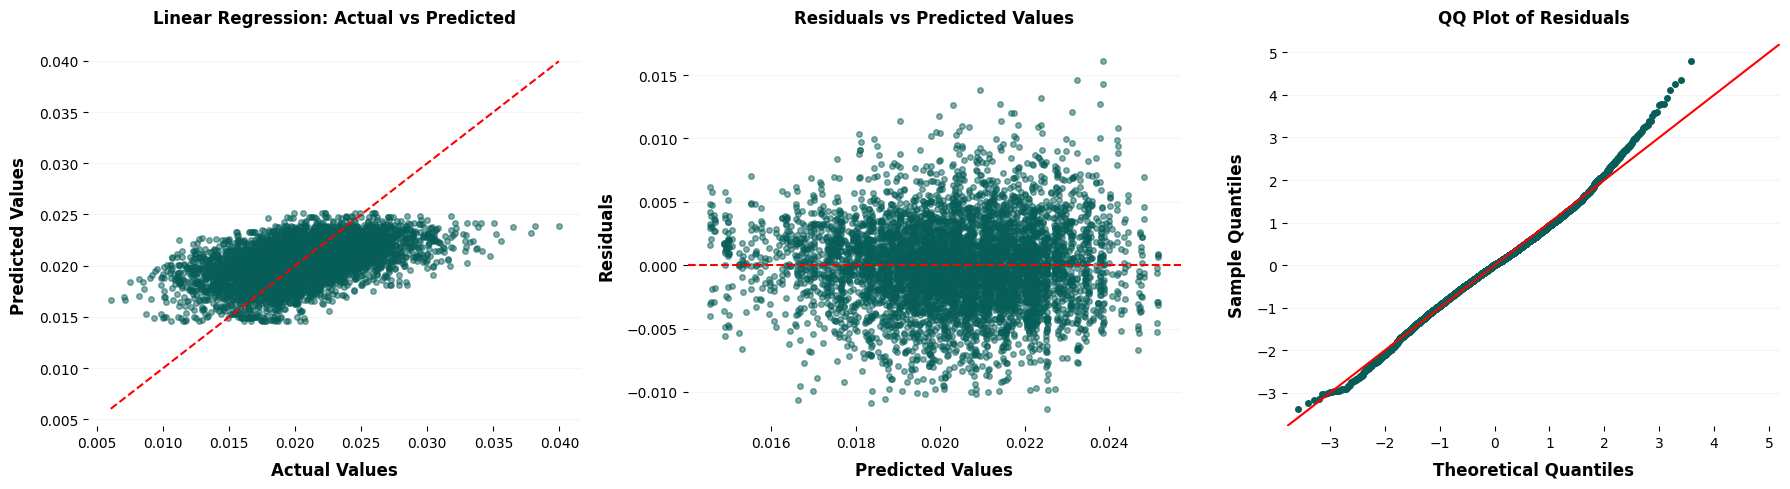

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Actual vs Predicted Values
axs[0].scatter(y_full, y_pred_lr, alpha=0.5)
axs[0].plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], color='red', linestyle='--')
axs[0].set_title('Linear Regression: Actual vs Predicted')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')

# 2. Residuals vs Predicted Values
residuals = y_full - y_pred_lr
axs[1].scatter(y_pred_lr, residuals, alpha=0.5)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title('Residuals vs Predicted Values')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# 3. QQ Plot for Residuals
sm.qqplot(residuals, line='45', fit=True, ax=axs[2])
axs[2].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

# 5. Saving the model

In [27]:
# Save the final model using joblib
def save_model(model, filename):
    """
    Save the model to a file using joblib.

    Parameters:
    model : The model object to be saved.
    filename : str, the path and name of the file where the model will be saved.

    Returns:
    None
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")
    

save_model(lr_model, 'outputs/lr_model.pkl')

Model saved to outputs/lr_model.pkl


# Do we need this code ?

In [28]:
# Custom transformer to allow parameter selection for different PCA methods
class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, method='PCA', n_components=2, kernel='linear'):
        self.method = method
        self.n_components = n_components
        self.kernel = kernel
        self.pca_ = None

    def fit(self, X, y=None):
        if self.method == 'PCA':
            self.pca_ = PCA(n_components=self.n_components)
        elif self.method == 'KernelPCA':
            self.pca_ = KernelPCA(n_components=self.n_components, kernel=self.kernel)
        elif self.method == 'SparsePCA':
            self.pca_ = SparsePCA(n_components=self.n_components)
        self.pca_.fit(X)
        return self

    def transform(self, X):
        return self.pca_.transform(X)

    def get_params(self, deep=True):
        return {'method': self.method, 'n_components': self.n_components, 'kernel': self.kernel}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

def find_best_pca_for_forecasting(df, age_columns, target_column, n_components_range=[2, 5, 10], kernel_options=['linear', 'poly', 'rbf']):
    # Prepare the features and target variable
    X = df[age_columns]
    y = df[target_column]
    
    # Define the parameter grid
    param_grid = [
        { 'pca__method': ['PCA'], 'pca__n_components': n_components_range },
        { 'pca__method': ['KernelPCA'], 'pca__n_components': n_components_range, 'pca__kernel': kernel_options },
        { 'pca__method': ['SparsePCA'], 'pca__n_components': n_components_range },
    ]

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', CustomPCA()),  # Custom PCA wrapper
        ('regressor', LinearRegression())
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X, y)
    
    # Get the best estimator
    best_pipeline = grid_search.best_estimator_
    
    # Split the data into training and test sets for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the best pipeline on the training data
    best_pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    
    # Evaluate the performance
    r2 = r2_score(y_test, y_pred)
    
    print(f'Best PCA Method: {grid_search.best_params_["pca__method"]}')
    print(f'Best PCA n_components: {grid_search.best_params_["pca__n_components"]}')
    if 'pca__kernel' in grid_search.best_params_:
        print(f'Best Kernel: {grid_search.best_params_["pca__kernel"]}')
    print(f'R² Score: {r2}')
    
    return best_pipeline


In [29]:
best_pca = find_best_pca_for_forecasting(complete_dataset_df, PCA_COLS, TARGET__COL, n_components_range=[2,3,4,5,6])

Best PCA Method: SparsePCA
Best PCA n_components: 4
R² Score: 0.1733111367398381


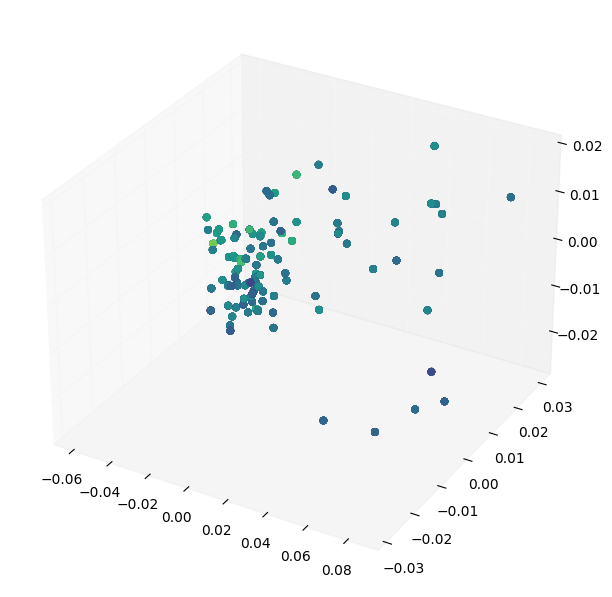

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7.5), subplot_kw={'projection': '3d'})
x_trans = best_pca.named_steps['pca'].transform(X_train_age_groups)
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train)

plt.show()

# All the code below (backup) will be removed once the above code is approved

In [ ]:
# # Converting 'month' to cyclic sine and cosine values (To preserve the cyclic nature)
# def convert_month_to_cyclic(df):
#     df = df.copy()
#     df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
#     df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
#     df = df.drop('month', axis=1)
#     return df

# complete_dataset_df = complete_dataset_df = convert_month_to_cyclic(complete_dataset_df)

# test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
# train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

# PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
# MONTH_COLS = ['month_sin', 'month_cos']
# TARGET__COL = 'appts_per_person_per_workingday'

# # Select the relevant columns from complete_dataset_df
# X_train_age_groups = train_set[PCA_COLS]
# X_train_months = train_set[MONTH_COLS]
# y_train = train_set[TARGET__COL]

# X_test_age_groups = test_set[PCA_COLS]
# X_test_months = test_set[MONTH_COLS]
# y_test = test_set[TARGET__COL]

# # Perform PCA on the age groups
# pca = PCA(n_components=3)
# X_train_age_trans = pca.fit_transform(X_train_age_groups)
# X_test_age_trans = pca.transform(X_test_age_groups)

# # Combine the PCA-transformed age groups with the original month columns (no PCA on month features)
# X_train_final = np.hstack([X_train_age_trans, X_train_months])
# X_test_final = np.hstack([X_test_age_trans, X_test_months])

# # Train a linear regression model
# model = LinearRegression()
# model.fit(X_train_final, y_train)

# # Predict appts_per_person_per_workingday using the PCA of age groups
# y_pred = model.predict((X_test_final))

In [ ]:
# # Feature importance (coefficients) from LR Model
# feature_importance = pd.DataFrame({
#     'Feature': X_full.columns,
#     'Coefficient': lr_model.coef_.round(4)
# })
# # Sort by absolute value of coefficients (magnitude)
# feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
# feature_importance = feature_importance.sort_values(by='abs_coef', ascending=False)
# # Print the feature importance with magnitudes
# print(feature_importance[['Feature', 'abs_coef']])


# # Feature importance from Gradient Boosting Model
# importance = best_model.feature_importances_
# importance_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': importance})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)


# # Plotting
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# # First plot (Linear Regression Coefficients)
# ax[0].barh(feature_importance['Feature'], feature_importance['abs_coef'])
# ax[0].set_title('Linear Regression Feature Importance\n(Coefficient Magnitude)')
# ax[0].set_xlabel('Absolute Coefficient Value')

# # Second plot (Gradient Boosting Feature Importance)
# ax[1].barh(importance_df['Feature'], importance_df['Importance'])
# ax[1].set_title('Gradient Boosting Feature Importance')
# ax[1].set_xlabel('Importance')

# plt.tight_layout()
# plt.show()

In [ ]:
# # Tune hyperparameters using GridSearchCV
# def tune_hyperparameters(X_train, y_train, model, param_grid):
#     grid_search = GridSearchCV(model, param_grid, cv=KFold(5), scoring='neg_mean_squared_error')
#     grid_search.fit(X_train, y_train)
#     return grid_search.best_estimator_, grid_search.best_params_

# # Evaluate the model using RMSE and MAE
# def calculate_metrics(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     return rmse, mae

# def evaluate_multiple_models(X_train, X_test, y_train, y_test):
#     models = {
#     'RandomForest': {
#         'model': RandomForestRegressor(),
#         'params': {
#             'n_estimators': [100, 300, 500],    # Number of trees in the forest; more trees can improve accuracy but increase training time.
#             'max_depth': [None, 10],            # Maximum depth of the tree; deeper trees can model more complex relationships.
#             'min_samples_split': [5, 10],       # Minimum number of samples required to split an internal node; controls overfitting.
#         }
#     },
#     'LinearRegression': {
#         'model': LinearRegression(),
#         'params': {
#             'fit_intercept': [True, False],
#             'copy_X': [True, False],
#             'n_jobs': [None, -1, 1, 2]
#         }
#     },
#     'Lasso': {
#             'model': Lasso(),
#             'params': {
#                 'alpha': [0.01, 0.1, 1, 10],    # Regularization strength; higher values mean more regularization
#                 'fit_intercept': [True, False],
#                 'max_iter': [1000, 5000]        # Maximum number of iterations for convergence
#             }
#         },
#     'Ridge': {
#             'model': Ridge(),
#             'params': {
#                 'alpha': [0.01, 0.1, 1, 10],
#                 'fit_intercept': [True, False],
#                 'solver': ['auto', 'saga']      # Solver to use in the computation
#             }
#         },
#     'GradientBoosting': {
#         'model': GradientBoostingRegressor(),
#         'params': {
#             'n_estimators': [100, 200, 300],    # Number of boosting stages to be run; more can lead to better performance but increase computation.
#             'learning_rate': [0.01, 0.1],       # Step size shrinkage; smaller values can improve performance at the cost of more trees needed.
#             'max_depth': [3, 5],                # Maximum depth of the individual trees; helps prevent overfitting.
#             'min_samples_split': [2, 5]         # Minimum number of samples required to split an internal node; higher values can control overfitting.
#         }
#     },
#     'KNeighbors': {
#         'model': KNeighborsRegressor(),
#         'params': {
#             'n_neighbors': [3, 5, 10],
#             'weights': ['uniform', 'distance'], # Number of neighbors to consider; impacts bias-variance tradeoff.
#             'algorithm': ['auto', 'ball_tree'], # Weighting function; can improve accuracy by emphasizing closer neighbors.
#         }
#     }
#     }

#     results = []
#     best_model = None
#     best_rmse = float('inf')
#     best_mae = float('inf')
#     best_params = None
    
#     model_dict = {}  # Dictionary to store models

#     for model_name, model_info in models.items():
#         print(f"Training {model_name}...")
#         tuned_model, tuned_params = tune_hyperparameters(X_train, y_train, model_info['model'], model_info['params'])
#         rmse, mae = calculate_metrics(tuned_model, X_test, y_test)

#         results.append({
#             'Model': model_name,
#             'Best Params': tuned_params,
#             'RMSE': rmse,
#             'MAE': mae
#         })
        
#         # Store the trained model in model_dict
#         model_dict[model_name] = tuned_model

#         # Update best model based on RMSE
#         if rmse < best_rmse:
#             best_model = tuned_model
#             best_rmse = rmse
#             best_mae = mae
#             best_params = tuned_params

#     # Convert results to DataFrame for table-like output
#     results_df = pd.DataFrame(results)

#     return best_model, results_df, model_dict

# best_model, results_df, model_dict = evaluate_multiple_models(X_train_final, X_test_final, y_train, y_test)

# pd.set_option('display.max_colwidth', None)
# results_df